# Ticketklassifikation mit BERT

Orientierungsquelle: https://towardsdatascience.com/multi-class-text-classification-with-deep-learning-using-bert-b59ca2f5c613

### Benötigte Pakete importieren

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

import json
import IProgress
import time
import random

import torch
from tqdm.notebook import tqdm
from torch.utils.data import DataLoader, RandomSampler, SequentialSampler
from torch.utils.data import TensorDataset
import torch.nn as nn

from transformers import BertTokenizer, BertForSequenceClassification
from transformers import DistilBertTokenizer, DistilBertForSequenceClassification
from transformers import AdamW, get_linear_schedule_with_warmup

from sklearn.model_selection import train_test_split
from sklearn.utils.class_weight import compute_class_weight
from sklearn.metrics import classification_report, confusion_matrix, balanced_accuracy_score
from sklearn.metrics import f1_score

### Finanz-Ticketdaten importieren und betrachten

In [2]:
finance_ticket_df = pd.read_excel('finance_tickets_cleaned_with_topics.xlsx')
finance_ticket_df.head(5)

,Unnamed: 0,Meldung,Ticketart,Meldung_cleaned,Meldung_BERT,Länge,Meldung_lemmatized
0,0,Good morning my name is XXXX XXXX and I apprec...,0,good morning name appreciate could help put st...,good morning my name is and appreciate it if y...,75,good morning name appreciate could help put st...
1,1,I upgraded my XXXX XXXX card in XX/XX/2018 and...,1,upgraded card told agent upgrade anniversary d...,i upgraded my card in and was told by the agen...,56,upgrade card tell agent upgrade anniversary da...
2,2,Chase Card was reported on XX/XX/2019. However...,1,chase card reported however fraudulent applica...,chase card was reported on however fraudulent ...,31,chase card report however fraudulent applicati...
3,3,"On XX/XX/2018, while trying to book a XXXX XX...",1,trying book ticket came across offer applied t...,on while trying to book ticket came across an ...,240,try book ticket come across offer apply toward...
4,4,my grand son give me check for {$1600.00} i de...,0,grand son give check deposit chase account fun...,my grand son give me check for deposit it into...,88,grand son give check deposit chase account fun...


In [3]:
ticket_df = finance_ticket_df[['Meldung', 'Meldung_BERT', 'Ticketart']].copy()
ticket_df.rename(columns={'Ticketart': 'Klasse'}, inplace=True)
ticket_df.head(5)

,Meldung,Meldung_BERT,Klasse
0,Good morning my name is XXXX XXXX and I apprec...,good morning my name is and appreciate it if y...,0
1,I upgraded my XXXX XXXX card in XX/XX/2018 and...,i upgraded my card in and was told by the agen...,1
2,Chase Card was reported on XX/XX/2019. However...,chase card was reported on however fraudulent ...,1
3,"On XX/XX/2018, while trying to book a XXXX XX...",on while trying to book ticket came across an ...,1
4,my grand son give me check for {$1600.00} i de...,my grand son give me check for deposit it into...,0


In [4]:
mapping_classes = {0: 'Bank Account services', 1: 'Credit card or prepaid card', 2: 'Others', 3: 'Theft/Dispute Reporting', 4: 'Mortgage/Loan'}
ticket_df['Ticketart'] = ticket_df['Klasse'].map(mapping_classes)
ticket_df['Ticketart'].value_counts()

Bank Account services          4888
Credit card or prepaid card    4802
Theft/Dispute Reporting        4131
Others                         3295
Mortgage/Loan                  2106
Name: Ticketart, dtype: int64

In [5]:
ticket_df['Klasse'].value_counts()

0    4888
1    4802
3    4131
2    3295
4    2106
Name: Klasse, dtype: int64

### Finanz-Ticketdaten splitten

In [6]:
from sklearn.model_selection import train_test_split

X_train, X_val, y_train, y_val = train_test_split(ticket_df.index.values, ticket_df.Klasse.values, test_size=0.15, random_state=24, stratify=ticket_df.Klasse.values)

ticket_df['data_type'] = ['not_set']*ticket_df.shape[0]

ticket_df.loc[X_train, 'data_type'] = 'train'
ticket_df.loc[X_val, 'data_type'] = 'val'

ticket_df.head()

,Meldung,Meldung_BERT,Klasse,Ticketart,data_type
0,Good morning my name is XXXX XXXX and I apprec...,good morning my name is and appreciate it if y...,0,Bank Account services,val
1,I upgraded my XXXX XXXX card in XX/XX/2018 and...,i upgraded my card in and was told by the agen...,1,Credit card or prepaid card,val
2,Chase Card was reported on XX/XX/2019. However...,chase card was reported on however fraudulent ...,1,Credit card or prepaid card,val
3,"On XX/XX/2018, while trying to book a XXXX XX...",on while trying to book ticket came across an ...,1,Credit card or prepaid card,train
4,my grand son give me check for {$1600.00} i de...,my grand son give me check for deposit it into...,0,Bank Account services,train


### BERT-Tokenizer importieren und Ticketmeldungen kodieren

In [7]:
tokenizer = BertTokenizer.from_pretrained('bert-base-uncased', do_lower_case=True)

In [8]:
ticket_df = ticket_df[ticket_df.Meldung_BERT.notna()]

In [9]:
encoded_data_train = tokenizer.batch_encode_plus(
    ticket_df[ticket_df.data_type=='train'].Meldung_BERT.values, 
    add_special_tokens=True, 
    return_attention_mask=True, 
    pad_to_max_length=True, 
    max_length=256, 
    return_tensors='pt'
)

encoded_data_val = tokenizer.batch_encode_plus(
    ticket_df[ticket_df.data_type=='val'].Meldung_BERT.values, 
    add_special_tokens=True, 
    return_attention_mask=True, 
    pad_to_max_length=True, 
    max_length=256, 
    return_tensors='pt'
)

input_ids_train = encoded_data_train['input_ids']
attention_masks_train = encoded_data_train['attention_mask']
labels_train = torch.tensor(ticket_df[ticket_df.data_type=='train'].Klasse.values)

input_ids_val = encoded_data_val['input_ids']
attention_masks_val = encoded_data_val['attention_mask']
labels_val = torch.tensor(ticket_df[ticket_df.data_type=='val'].Klasse.values)

dataset_train = TensorDataset(input_ids_train, attention_masks_train, labels_train)
dataset_val = TensorDataset(input_ids_val, attention_masks_val, labels_val)

Truncation was not explicitly activated but `max_length` is provided a specific value, please use `truncation=True` to explicitly truncate examples to max length. Defaulting to 'longest_first' truncation strategy. If you encode pairs of sequences (GLUE-style) with the tokenizer you can select this strategy more precisely by providing a specific strategy to `truncation`.
/opt/conda/lib/python3.10/site-packages/transformers/tokenization_utils_base.py:2346: FutureWarning: The `pad_to_max_length` argument is deprecated and will be removed in a future version, use `padding=True` or `padding='longest'` to pad to the longest sequence in the batch, or use `padding='max_length'` to pad to a max length. In this case, you can give a specific length with `max_length` (e.g. `max_length=45`) or leave max_length to None to pad to the maximal input size of the model (e.g. 512 for Bert).
  warnings.warn(


### BERT-Modell und Adam-Optimierer laden

In [10]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
model = BertForSequenceClassification.from_pretrained('bert-base-uncased', num_labels=5, output_attentions=False, output_hidden_states=False)
model.to(device)

Some weights of the model checkpoint at bert-base-uncased were not used when initializing BertForSequenceClassification: ['cls.predictions.transform.dense.bias', 'cls.seq_relationship.weight', 'cls.predictions.transform.LayerNorm.bias', 'cls.predictions.bias', 'cls.predictions.transform.dense.weight', 'cls.predictions.decoder.weight', 'cls.predictions.transform.LayerNorm.weight', 'cls.seq_relationship.bias']
- This IS expected if you are initializing BertForSequenceClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertForSequenceClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at

BertForSequenceClassification(
  (bert): BertModel(
    (embeddings): BertEmbeddings(
      (word_embeddings): Embedding(30522, 768, padding_idx=0)
      (position_embeddings): Embedding(512, 768)
      (token_type_embeddings): Embedding(2, 768)
      (LayerNorm): LayerNorm((768,), eps=1e-12, elementwise_affine=True)
      (dropout): Dropout(p=0.1, inplace=False)
    )
    (encoder): BertEncoder(
      (layer): ModuleList(
        (0): BertLayer(
          (attention): BertAttention(
            (self): BertSelfAttention(
              (query): Linear(in_features=768, out_features=768, bias=True)
              (key): Linear(in_features=768, out_features=768, bias=True)
              (value): Linear(in_features=768, out_features=768, bias=True)
              (dropout): Dropout(p=0.1, inplace=False)
            )
            (output): BertSelfOutput(
              (dense): Linear(in_features=768, out_features=768, bias=True)
              (LayerNorm): LayerNorm((768,), eps=1e-12, element

In [11]:
batch_size = 3
dataloader_train = DataLoader(dataset_train, sampler=RandomSampler(dataset_train), batch_size=batch_size)
dataloader_validation = DataLoader(dataset_val, sampler=SequentialSampler(dataset_val), batch_size=batch_size)

In [12]:
optimizer = AdamW(model.parameters(), lr=1e-5, eps=1e-8)
epochs = 6
scheduler = get_linear_schedule_with_warmup(optimizer, num_warmup_steps=0, num_training_steps=len(dataloader_train)*epochs)

/opt/conda/lib/python3.10/site-packages/transformers/optimization.py:391: FutureWarning: This implementation of AdamW is deprecated and will be removed in a future version. Use the PyTorch implementation torch.optim.AdamW instead, or set `no_deprecation_warning=True` to disable this warning
  warnings.warn(


### Evaluierungsfunktionen definieren

In [13]:
label_dict = {"Bank Account services": 0, "Credit card or prepaid card": 1, "Others": 2, "Theft/Dispute Reporting": 3, "Mortgage/Loan": 4}

In [14]:
def f1_score_func(preds, labels):
    preds_flat = np.argmax(preds, axis=1).flatten()
    labels_flat = labels.flatten()
    return f1_score(labels_flat, preds_flat, average='weighted')

def accuracy_per_class(preds, labels):
    label_dict_inverse = {v: k for k, v in label_dict.items()}
    
    preds_flat = np.argmax(preds, axis=1).flatten()
    labels_flat = labels.flatten()

    for label in np.unique(labels_flat):
        y_preds = preds_flat[labels_flat==label]
        y_true = labels_flat[labels_flat==label]
        print(f'Class: {label_dict_inverse[label]}')
        print(f'Accuracy: {len(y_preds[y_preds==label])}/{len(y_true)}\n')

In [15]:
seed_val = 24
random.seed(seed_val)
np.random.seed(seed_val)
torch.manual_seed(seed_val)
torch.cuda.manual_seed_all(seed_val)

In [16]:
def evaluate(dataloader_val):

    model.eval()
    
    loss_val_total = 0
    correct_predictions = 0
    predictions, true_vals = [], []
    
    for batch in dataloader_val:
        
        batch = tuple(b.to(device) for b in batch)
        
        inputs = {'input_ids':      batch[0],
                  'attention_mask': batch[1],
                  'labels':         batch[2],
                 }

        with torch.no_grad():        
            outputs = model(**inputs)
            
        loss = outputs[0]
        logits = outputs[1]
        loss_val_total += loss.item()

        logits = logits.detach().cpu().numpy()
        label_ids = inputs['labels'].cpu().numpy()
        predictions.append(logits)
        true_vals.append(label_ids)
        
        preds = np.argmax(logits, axis=1)
        correct_predictions += np.sum(preds == label_ids)
    
    loss_val_avg = loss_val_total/len(dataloader_val)
    validation_accuracy = correct_predictions/len(dataloader_val.dataset)
    
    predictions = np.concatenate(predictions, axis=0)
    true_vals = np.concatenate(true_vals, axis=0)
            
    return loss_val_avg, predictions, true_vals, validation_accuracy

In [17]:
def evaluate_classification_report(dataloader_val):

    model.eval()
    
    loss_val_total = 0
    predictions, true_vals = [], []
    
    for batch in dataloader_val:
        
        batch = tuple(b.to(device) for b in batch)
        
        inputs = {'input_ids':      batch[0],
                  'attention_mask': batch[1],
                  'labels':         batch[2],
                 }

        with torch.no_grad():        
            outputs = model(**inputs)
            
        loss = outputs[0]
        logits = outputs[1]
        loss_val_total += loss.item()

        logits = logits.detach().cpu().numpy()
        label_ids = inputs['labels'].cpu().numpy()
        predictions.extend(np.argmax(logits, axis=1))
        true_vals.extend(label_ids)
    
    loss_val_avg = loss_val_total/len(dataloader_val) 
    classification_report_output = classification_report(true_vals, predictions, output_dict=True)
    confusion_matrix_output = confusion_matrix(true_vals, predictions)
    balanced_accuracy = balanced_accuracy_score(true_vals, predictions)
            
    return loss_val_avg, classification_report_output, confusion_matrix_output, balanced_accuracy

### Verlustfunktion anpassen

In [18]:
labels_train_numpy = labels_train.cpu().numpy()
class_weights = compute_class_weight(class_weight='balanced', classes=np.unique(labels_train_numpy), y=labels_train_numpy)
weights = torch.tensor(class_weights, dtype=torch.float32).to(device)

loss_fn = nn.CrossEntropyLoss(weight=weights)

### Trainingsschleife

In [19]:
loss_values = []
accuracy_values = []
training_times = []

for epoch in tqdm(range(1, epochs+1)):
    
    start_time_bert = time.time()
    
    model.train()
    
    loss_train_total = 0

    progress_bar = tqdm(dataloader_train, desc='Epoch {:1d}'.format(epoch), leave=False, disable=False)
    for batch in progress_bar:

        model.zero_grad()
        
        batch = tuple(b.to(device) for b in batch)
        
        inputs = {'input_ids':      batch[0],
                  'attention_mask': batch[1],
                  'labels':         batch[2],
                 }       

        outputs = model(**inputs)
        
        loss = loss_fn(outputs[1], inputs['labels'])
        loss_train_total += loss.item()
        loss.backward()

        torch.nn.utils.clip_grad_norm_(model.parameters(), 1.0)

        optimizer.step()
        scheduler.step()
        
        progress_bar.set_postfix({'training_loss': '{:.3f}'.format(loss.item()/len(batch))})
         
    torch.save(model.state_dict(), f'finetuned_BERT_epoch_{epoch}.model')
        
    tqdm.write(f'\nEpoch {epoch}')
    
    loss_train_avg = loss_train_total/len(dataloader_train)            
    tqdm.write(f'Training loss: {loss_train_avg}')
    
    val_loss, predictions, true_vals, val_accuracy = evaluate(dataloader_validation)
    val_f1 = f1_score_func(predictions, true_vals)
    tqdm.write(f'Validation loss: {val_loss}')
    tqdm.write(f'F1 Score (Weighted): {val_f1}')
    
    loss_values.append(round(val_loss, 3))
    accuracy_values.append(round(val_accuracy, 3))
    
    end_time_bert = time.time()

    training_times.append(end_time_bert - start_time_bert)

  0%|          | 0/6 [00:00<?, ?it/s]

Epoch 1:   0%|          | 0/5446 [00:00<?, ?it/s]


Epoch 1
Training loss: 0.5105713777672483
Validation loss: 0.418216095649235
F1 Score (Weighted): 0.9038523689663776


Epoch 2:   0%|          | 0/5446 [00:00<?, ?it/s]


Epoch 2
Training loss: 0.32292202831129363
Validation loss: 0.426564162634635
F1 Score (Weighted): 0.9107715629459615


Epoch 3:   0%|          | 0/5446 [00:00<?, ?it/s]


Epoch 3
Training loss: 0.2169958656388538
Validation loss: 0.6977298574252822
F1 Score (Weighted): 0.8898188661980874


Epoch 4:   0%|          | 0/5446 [00:00<?, ?it/s]


Epoch 4
Training loss: 0.1329835213025676
Validation loss: 0.5298056684125239
F1 Score (Weighted): 0.9173206572416238


Epoch 5:   0%|          | 0/5446 [00:00<?, ?it/s]


Epoch 5
Training loss: 0.07167550079683038
Validation loss: 0.5998120734698233
F1 Score (Weighted): 0.9188215973877021


Epoch 6:   0%|          | 0/5446 [00:00<?, ?it/s]


Epoch 6
Training loss: 0.03715025023753493
Validation loss: 0.6155349618150234
F1 Score (Weighted): 0.9178526569477768


### Val.verlust und Val.genauigkeit im Trainingsprozess beobachten

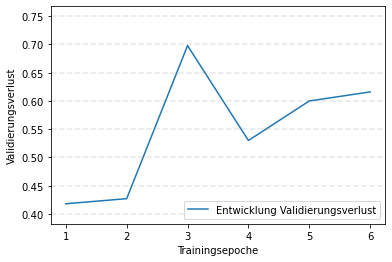

In [20]:
fig, ax = plt.subplots()
ax.plot(range(1, epochs+1), loss_values, label='Entwicklung Validierungsverlust')
ax.set_xlabel('Trainingsepoche')
ax.set_ylabel('Validierungsverlust')
ax.legend(loc='lower right')

plt.xticks(range(1, epochs+1))

for y in ax.yaxis.get_ticklocs():
    ax.axhline(y, color='gray', alpha=0.2, linestyle='--')
   
plt.show()

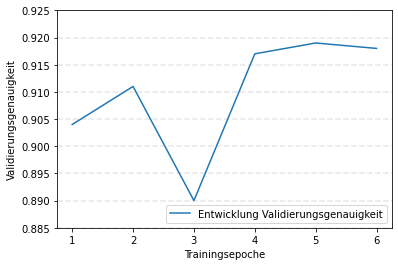

In [21]:
fig, ax = plt.subplots()
ax.plot(range(1, epochs+1), accuracy_values, label='Entwicklung Validierungsgenauigkeit')
ax.set_xlabel('Trainingsepoche')
ax.set_ylabel('Validierungsgenauigkeit')
ax.legend(loc='lower right')

plt.yticks(ax.get_yticks(), [f'{val:.3f}' for val in ax.get_yticks()])
plt.xticks(range(1, epochs+1))

for y in ax.yaxis.get_ticklocs():
    ax.axhline(y, color='gray', alpha=0.2, linestyle='--')

plt.show()

### Bestes Modell laden und evaluieren

In [22]:
total_training_time_bert = 0
for i in range(4):
    total_training_time_bert += training_times[i]
    
total_training_time_bert

1598.7793924808502

In [23]:
model = BertForSequenceClassification.from_pretrained('bert-base-uncased', num_labels=5, output_attentions=False, output_hidden_states=False)
# model = DistilBertForSequenceClassification.from_pretrained('distilbert-base-german-cased', num_labels=5, output_attentions=False, output_hidden_states=False)
model.to(device)

model.load_state_dict(torch.load('finetuned_BERT_epoch_4.model', map_location=torch.device('cuda')))
# model.load_state_dict(torch.load('finetuned_DistilBERT_epoch_5.model', map_location=torch.device('cuda')))

_, predictions, true_vals, val_accuracy = evaluate(dataloader_validation)
accuracy_per_class(predictions, true_vals)

Some weights of the model checkpoint at bert-base-uncased were not used when initializing BertForSequenceClassification: ['cls.predictions.transform.dense.bias', 'cls.seq_relationship.weight', 'cls.predictions.transform.LayerNorm.bias', 'cls.predictions.bias', 'cls.predictions.transform.dense.weight', 'cls.predictions.decoder.weight', 'cls.predictions.transform.LayerNorm.weight', 'cls.seq_relationship.bias']
- This IS expected if you are initializing BertForSequenceClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertForSequenceClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at

Class: Bank Account services
Accuracy: 689/733

Class: Credit card or prepaid card
Accuracy: 677/721

Class: Others
Accuracy: 453/494

Class: Theft/Dispute Reporting
Accuracy: 541/620

Class: Mortgage/Loan
Accuracy: 286/316



In [24]:
loss_val_avg, classification_report_output, confusion_matrix_output, balanced_accuracy = evaluate_classification_report(dataloader_validation)

### Evaluierungswerte des BERT-Modells zwischenspeichern

In [25]:
bert_values = {
    "training_time_bert": total_training_time_bert,
    "accuracy_bert":classification_report_output['accuracy'],
    "balanced_accuracy_bert": balanced_accuracy,
    "f1_score_macro_bert": classification_report_output['macro avg']['f1-score'],
    "f1_score_weighted_bert": classification_report_output['weighted avg']['f1-score']
}

json_bert = json.dumps(bert_values)
    
with open('value_cache_bert_finance', 'w') as f:
    f.write(json_bert)